<a href="https://colab.research.google.com/github/rik030/MyoPS-2020/blob/main/MyoPS(cGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
base_dir = '/content/drive/My Drive/Colab Notebooks'
os.chdir(base_dir)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

In [ ]:
from numpy import zeros
from numpy import ones
import numpy as np
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
import tensorflow as tf

In [ ]:
!pip install tqdm

In [ ]:
from glob import glob
def load_data(path):
    """ X = Images and Y = masks """

    X = sorted(glob(os.path.join(path, "images", "*.npy")))
    Y = sorted(glob(os.path.join(path, "gts", "*.npy")))

    return (X,Y)

data_path='/content/drive/MyDrive/Colab Notebooks/myo_208/'
(X, Y)= load_data(data_path)    

In [ ]:
#Data Augmentation
from tqdm import tqdm
from albumentations import HorizontalFlip, VerticalFlip, Rotate

def augment_data(images, masks, save_path, augment=True):
    H = 208
    W = 208

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting names """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = np.load(x)
        y = np.load(y)
        #print(x)
        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug=Rotate(limit=120, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            # aug=Affine(scale=0.2, p=1.0)
            # augmented = aug(image=x, mask=y)
            # x5 = augmented["image"]
            # y5 = augmented["mask"]

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            '''i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))'''
           # print(len(X))
            if len(X) == 1:
                tmp_image_name = f"{name}.npy"
                tmp_mask_name = f"{name}.npy"
            else:
                tmp_image_name = f"{name}_{index}.npy"
                tmp_mask_name = f"{name}_{index}.npy"

            image_path = os.path.join(save_path, "images", tmp_image_name)
            mask_path = os.path.join(save_path, "gts", tmp_mask_name)
            # cv2.imwrite(image_path, i)
            # cv2.imwrite(mask_path, m)
            np.save(image_path,i)
            np.save(mask_path,m)
            '''raise Exception("Could not write image")'''

            index += 1

augment_data(X, Y, "/content/drive/MyDrive/Colab Notebooks/aug_myo_208/", augment=True)

  6%|▌         | 6/102 [00:46<12:25,  7.77s/it]


KeyboardInterrupt: ignored

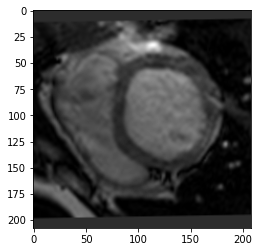

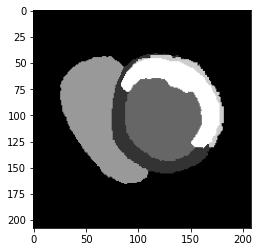

In [ ]:
img=np.load("/content/drive/MyDrive/Colab Notebooks/aug_myo_208/images/id_101_3.npy")
gt=np.load("/content/drive/MyDrive/Colab Notebooks/aug_myo_208/gts/id_101_3.npy")
plt.imshow(img[:,:,0],cmap='gray')
plt.show()
plt.imshow(gt[:,:], cmap='gray')
plt.show()

In [ ]:
len(os.listdir("/content/drive/MyDrive/Colab Notebooks/aug_myo_208/gts"))

408

In [ ]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

# load all images in a directory into memory
def load_images(path,size=(208,208)):
    src_list= list()
    # enumerate filenames in directory, assume all are images
    for filename in sorted(listdir(path)):
      # load and resize the image
      img = np.load(path +'/'+ filename)
      src_list.append(img)
    return np.asarray(src_list)
 
def load_gts(path,size=(208,208)):
    tar_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in sorted(listdir(path)):
      # load and resize the image
      img = np.load(path +'/'+ filename)
      img=np.expand_dims(img, axis=2)
      tar_list.append(img)
    return np.asarray(tar_list)
 
# dataset path
image_path='/content/drive/MyDrive/Colab Notebooks/myo_208/images'

gt_path='/content/drive/MyDrive/Colab Notebooks/myo_208/gts'
# load dataset
[src_images, tar_images] = [load_images(image_path), load_gts(gt_path)]
print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (102, 208, 208, 3) (102, 208, 208, 1)


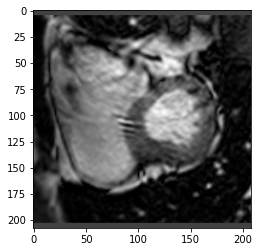

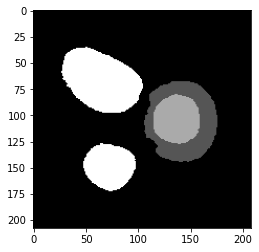

In [ ]:
plt.imshow(src_images[10,:,:,0],cmap='gray')
plt.show()
plt.imshow(tar_images[10,:,:,0],cmap='gray')
plt.show()

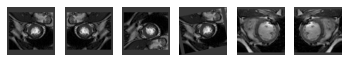

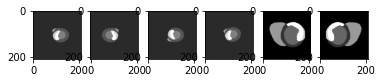

In [ ]:
#Plotting
n_samples = 6
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i,:,:,0], cmap='gray')
pyplot.show()
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.imshow(tar_images[i,:,:,0], cmap='gray')
pyplot.show()

In [ ]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 7.3 MB/s 


In [ ]:
from segmentation_models.losses import CategoricalCELoss
# class_weights=np.load("/content/drive/MyDrive/Colab Notebooks/Vox2Vox/class_weights.npy")
class_weights=[0.01,0.15,0.14,0.1,0.35,0.25]
class_weights=np.asarray(class_weights)
loss1=CategoricalCELoss(class_weights=class_weights)

Segmentation Models: using `keras` framework.


In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [ ]:
"""  
Generator:    
The encoder-decoder architecture consists of:
encoder:
C64-C128-C256-C512-C512-C512-C512-C512
decoder:
CD512-CD512-CD512-C512-C256-C128-C64
Discriminator
C64-C128-C256-C512
After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.    
"""

from numpy import ones
from numpy.random import randint
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K


#############################################################################
#Define generator, discriminator, gan and other helper functions
#We will use functional way of defining model and not sequential
#as we have multiple inputs; both images and corresponding labels. 
########################################################################

#Since pix2pix is a conditional GAN, it takes 2 inputs - image and corresponding label
#For pix2pix the label will be another image. 

# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (1 or 0). So using sigmoid activation.
#Think of discriminator as a binary classifier that is classifying images as real/fake.

# From the paper C64-C128-C256-C512
#After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.  

def define_discriminator(image_shape):
      
    # weight initialization
    init = RandomNormal(stddev=0.02) #As described in the original paper
      
    # source image input
    in_target_image = Input(shape=image_shape)  #Image we want to convert to another image
    # target image input
    # in_target_image = Input(shape=image_shape)  #Image we want to generate after training
    # print("Input_shape", in_src_image.shape)
    # print("Target_shape", in_target_image.shape)
    # concatenate images, channel-wise
    # merged = Concatenate()([in_src_image, in_target_image])
      
    # C64: 4x4 kernel Stride 2x2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_target_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel Stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256: 4x4 kernel Stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512: 4x4 kernel Stride 2x2 
      # Not in the original paper. Comment this block if you want.
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer : 4x4 kernel but Stride 1x1
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(6, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    # print(patch_out.shape)
    model = Model(in_target_image, patch_out)
    # print(model.summary())
    # dot_img_file = 'dmodel.png'
    # plot_model(model, to_file=dot_img_file, show_shapes=True)
    # compile model
      #The model is trained with a batch size of one image and Adam opt. 
      #with a small learning rate and 0.5 beta. 
      #The loss for the discriminator is weighted by 50% for each model update.
      
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

# disc_model = define_discriminator((256,256,3))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    return conv

# define the standalone generator model - U-net
def define_generator(image_shape=(208,208,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    # in_image = Input(shape=image_shape)
    print("Entered gen")
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    dropout_rate=0.0
    batch_norm=True
    NUM_CLASSES=6
    inputs = layers.Input(image_shape, dtype=tf.float32)
  
    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)  #Change to softmax for multichannel

    # Model 
    model = models.Model(inputs, conv_final, name="UNet")
    # print(model.summary())
    return model

# gen_model = define_generator((256,256,3))
# plot_model(gen_model, to_file='gen_model.png', show_shapes=True)


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
      if not isinstance(layer, BatchNormalization):
        layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                  #standalone descriminator will be trainable.
              
    # define the source image
    in_src = Input(shape=image_shape)
    # suppy the image as input to the generator 
    gen_out = g_model(in_src)
    # print(gen_out.shape)
    # print("gen_out", type(gen_out))
    # supply the input image and generated image as inputs to the discriminator
    dis_out = d_model(gen_out)
    # src image as input, generated image and disc. output as outputs
    model = Model(in_src, [dis_out, gen_out])
    # print(model.summary())
    # dot_img_file = '/tmp/model_1.png'
    # plot_model(model, to_file=dot_img_file, show_shapes=True)
    # print(plot_model(model))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
      
      #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
      #Authors suggested weighting BCE vs L1 as 1:100.
    model.compile(loss=[loss1,'mae'], 
                optimizer=opt, loss_weights=[1,100])
    return model

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    XX=tf.keras.utils.to_categorical(X2, num_classes=6)
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 6))
    return [X1, XX], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # print(X.shape)
    # create 'fake' class labels (0)
    # print("X shape", X.shape)
    y = zeros((len(X), patch_shape, patch_shape, 6))
    return X, y

In [ ]:
# generate samples and save as a plot and save the model
#GAN models do not converge, we just want to find a good balance between
#the generator and the discriminator. Therefore, it makes sense to periodically
#save the generator model and check how good the generated image looks. 
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # X_fakeB=np.squeeze(X_fakeB)
    # print(X_fakeB.shape)
    # plt.imshow(X_fakeB[0,:,:])
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    # X_realB = (X_realB + 1) / 2.0
    # X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
      plt.subplot(3, n_samples, 1 + i)
      plt.axis('off')
      plt.imshow(X_realA[i,:,:,0], cmap='gray')
    # plot generated target image
    for i in range(n_samples):
      plt.subplot(3, n_samples, 1 + n_samples + i)
      plt.axis('off')
      plt.imshow(X_fakeB[i,:,:,0], cmap='gray')
    # plot real target image
    for i in range(n_samples):
      plt.subplot(3, n_samples, 1 + n_samples*2 + i)
      plt.axis('off')
      print("XRB", X_realB.shape)
      realB=np.argmax(X_realB, axis=-1)
      print("XRA", realB.shape)
      plt.imshow(realB[i,:,:], cmap='gray')
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
image_shape = src_images.shape[1:]
# image_shape=(256,256,1)
gt_shape=(208,208,6)
# print(gt_shape)
# define the models
d_model = define_discriminator(gt_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Entered gen


In [ ]:
X_train=src_images[0:360,:,:,:]
Y_train=tar_images[0:360,:,:,:]
X_valid=src_images[360:,:,:,:]
Y_valid=tar_images[360:,:,:,:]

In [ ]:
#Define data
# load and prepare training images (full dataset)
tdata = [src_images, tar_images]

def normalise_image(data):
    '''
    make image zero mean and unit standard deviation
    '''
    X1, X2 = data[0], data[1]
    img_o = np.float32(X1.copy())
    m = np.mean(img_o)
    s = np.std(img_o)
    XX=np.divide((img_o - m), s)
    return [XX, X2]	

train_dataset = normalise_image(tdata)

In [ ]:
#Define data
# load and prepare training images
tdata = [X_train, Y_train]

def normalise_image(data):
    '''
    make image zero mean and unit standard deviation
    '''
    X1, X2 = data[0], data[1]
    img_o = np.float32(X1.copy())
    m = np.mean(img_o)
    s = np.std(img_o)
    XX=np.divide((img_o - m), s)
    return [XX, X2]	

train_dataset = normalise_image(tdata)

In [ ]:
#Define data
# load and prepare validation images
vdata = [X_valid, Y_valid]

def normalise_image(data):
    '''
    make image zero mean and unit standard deviation
    '''
    X1, X2 = data[0], data[1]
    img_o = np.float32(X1.copy())
    m = np.mean(img_o)
    s = np.std(img_o)
    XX=np.divide((img_o - m), s)
    return [XX, X2]	

valid_dataset = normalise_image(vdata)

In [ ]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    print("dmodel: ", d_model.output_shape[1])
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    # print("Executed......")
    for i in range(n_steps):
      # select a batch of real samples
      [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
      # print(y_real.shape)
      # generate a batch of fake samples
      X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
      # update discriminator for real samples
      d_loss1 = d_model.train_on_batch(X_realB, y_real)
      # update discriminator for generated samples
      d_loss2 = d_model.train_on_batch(X_fakeB, y_fake)
      # update the generator
      g_loss,_,_ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
      # summarize performance
      print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
      # summarize model performance
      if (i+1) % (bat_per_epo * 20) == 0:
        summarize_performance(i, g_model, dataset)

In [ ]:
from datetime import datetime 
start1 = datetime.now() 

train(d_model, g_model, gan_model, train_dataset, n_epochs=100, n_batch=1) 
#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

Streaming output truncated to the last 5000 lines.
>5226, d1[0.001] d2[0.000] g[2.791]
>5227, d1[0.000] d2[0.000] g[4.189]
>5228, d1[0.000] d2[0.000] g[6.151]
>5229, d1[0.000] d2[0.000] g[2.803]
>5230, d1[0.001] d2[0.000] g[5.885]
>5231, d1[0.000] d2[0.000] g[5.569]
>5232, d1[0.000] d2[0.000] g[6.194]
>5233, d1[0.000] d2[0.001] g[6.583]
>5234, d1[0.000] d2[0.000] g[3.486]
>5235, d1[0.000] d2[0.000] g[3.906]
>5236, d1[0.000] d2[0.000] g[2.878]
>5237, d1[0.000] d2[0.000] g[3.168]
>5238, d1[0.000] d2[0.000] g[4.646]
>5239, d1[0.000] d2[0.000] g[3.981]
>5240, d1[0.000] d2[0.000] g[3.406]
>5241, d1[0.000] d2[0.000] g[4.864]
>5242, d1[0.000] d2[0.000] g[3.335]
>5243, d1[0.000] d2[0.000] g[4.716]
>5244, d1[0.000] d2[0.000] g[3.759]
>5245, d1[0.000] d2[0.000] g[3.384]
>5246, d1[0.000] d2[0.000] g[6.161]
>5247, d1[0.000] d2[0.000] g[3.604]
>5248, d1[0.000] d2[0.000] g[5.381]
>5249, d1[0.000] d2[0.000] g[3.061]
>5250, d1[0.000] d2[0.000] g[4.794]
>5251, d1[0.000] d2[0.000] g[5.562]
>5252, d1[0.0

In [ ]:
from keras.models import load_model
from numpy.random import randint
model = load_model('/content/drive/MyDrive/Colab Notebooks/model_100ep_13PG_UNet.h5')

In [ ]:
train_dataset

In [ ]:
[X1, X2] = train_dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
gn=np.argmax(gen_image, axis=3)

In [ ]:
ix

array([32])

In [ ]:
preds=np.empty((len(X1),208,208))
gts=np.empty((len(X1),208,208))
for i in range(len(X1)):
  t_im=np.squeeze(X2[i], axis=2)
  src=np.expand_dims(X1[i], axis=0)
  tar=np.expand_dims(t_im, axis=0)
  gen_im = model.predict(src)
  gn_im=np.argmax(gen_im, axis=3)
  gts[i]=tar
  preds[i]=gn_im

In [ ]:
X1[55][:,:,0].shape

(208, 208)

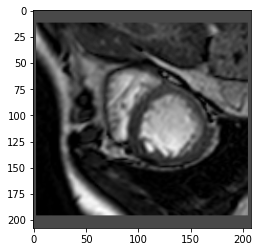

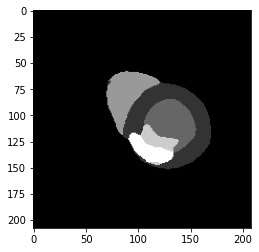

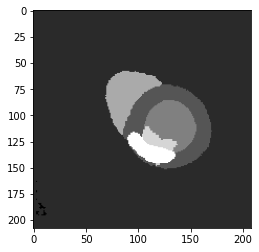

In [ ]:
i=26
plt.imshow(X1[i][:,:,0], cmap='gray')
plt.show()
plt.imshow(preds[i,:,:], cmap='gray')
plt.show()
plt.imshow(gts[i,:,:], cmap='gray')
plt.show()

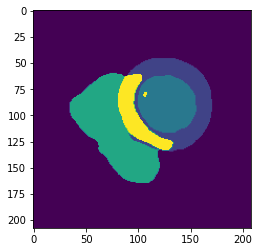

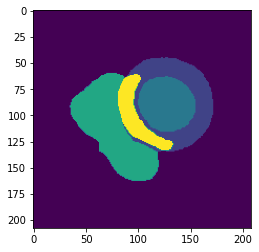

In [ ]:
plt.imshow(gn[0,:,:])
plt.show()
tar_im=np.squeeze(tar_image, axis=3)
plt.imshow(tar_im[0,:,:])
plt.show()

In [ ]:
def dice_coef_multilabel(y_true, y_pred):
    ytrue=np.array(tf.keras.utils.to_categorical(y_true, num_classes=6))
    ypred=np.array(tf.keras.utils.to_categorical(y_pred, num_classes=6))
    dice=[]
    for i in range(6):
        dice.append(dice_coef(ytrue[0,:,:,i], ypred[0,:,:,i]).numpy())
    return dice 

In [ ]:
def dice_coef_multi(y_true, y_pred):
    ytrue=np.array(tf.keras.utils.to_categorical(y_true, num_classes=6))
    ypred=np.array(tf.keras.utils.to_categorical(y_pred, num_classes=6))
    # print(ypred.shape)
    dice=[]
    for i in range(6):
        dice.append(dice_coef(ytrue[:,:,i], ypred[:,:,i]).numpy())
    return dice 

In [ ]:
res=np.empty((len(X1),6))
for i in range(len(X1)):
    res[i]=dice_coef_multi(gts[i], preds[i])

In [ ]:
import pandas as pd 
results=pd.DataFrame(res)

In [ ]:
results.to_csv("result_100ep_16PG_WOAug_208_shape_valid.csv")